# WeRateDogs Tweeter Archive

## Gather

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy

In [2]:
tweet = pd.read_csv('twitter-archive-enhanced.csv')

In [ ]:
###
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
if r.status_code == 200:
    with open('image_predictions.tsv', 'wb') as f:
        f.write(r.content)

In [3]:
image = pd.read_csv('image_predictions.tsv', sep = '\t')

In [ ]:
###
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True )

In [ ]:
###
from timeit import default_timer as timer

start = timer()
tweet_id = []
retweet_count = []
favorite_count = []

for ids in image.tweet_id:
    try:
        tweet = api.get_status(ids, tweet_mode='extended')
        tweet_id.append(ids)
        retweet_count.append(tweet.retweet_count)
        favorite_count.append(tweet.favorite_count)
    except Exception as e:
        print(str(e))
        
end = timer()
print(end - start)    

In [ ]:
###
file = open("tweet_json.txt", "w")
for index in range(len(tweet_id)):
    file.write(str(tweet_id[index]) + " " + str(retweet_count[index]) + " " + str(favorite_count[index]) + "\n")
file.close()

In [4]:
info = pd.read_csv('tweet_json.txt', sep=" ", header=None)
info.columns = ['tweet_id','retweet_count','favorite_count']

## Assess

In [5]:
tweet.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [6]:
image.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [7]:
info.head(10)

,tweet_id,retweet_count,favorite_count
0,666020888022790149,519,2521
1,666029285002620928,47,131
2,666033412701032449,45,125
3,666044226329800704,141,302
4,666049248165822465,40,109
5,666050758794694657,59,133
6,666051853826850816,864,1236
7,666055525042405380,258,441
8,666057090499244032,143,299
9,666058600524156928,58,114


In [8]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.0+ KB


In [10]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 3 columns):
tweet_id          2069 non-null int64
retweet_count     2069 non-null int64
favorite_count    2069 non-null int64
dtypes: int64(3)
memory usage: 48.6 KB


In [11]:
all_columns = pd.Series(list(tweet) + list(image) + list(info))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [12]:
list(tweet)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [13]:
list(image)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [14]:
tweet[tweet['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [15]:
tweet.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [16]:
image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
info.describe()

,tweet_id,retweet_count,favorite_count
count,2.069000e+03,2069.000000,2069.000000
mean,7.381251e+17,2895.317061,8575.327211
std,6.766215e+16,4891.074703,12506.787889
min,6.660209e+17,13.000000,0.000000
25%,6.764400e+17,618.000000,1648.000000
50%,7.117327e+17,1373.000000,3808.000000
75%,7.931355e+17,3365.000000,10822.000000
max,8.924206e+17,77903.000000,144091.000000


In [18]:
tweet.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2206,668631377374486528,NaN,NaN,2015-11-23 03:25:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Zeek. He is a grey Cumulonimbus. Zeek is ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668631377...,5,10,Zeek,None,None,None,None
655,791784077045166082,NaN,NaN,2016-10-27 23:30:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: I'm not sure what this dog is d...,6.820881e+17,4.196984e+09,2015-12-30 06:37:25 +0000,"https://vine.co/v/iqMjlxULzbn,https://vine.co/...",12,10,None,None,None,None,None
2010,672248013293752320,NaN,NaN,2015-12-03 02:56:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",10/10 for dog. 7/10 for cat. 12/10 for human. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672248013...,10,10,None,None,None,None,None
806,772102971039580160,NaN,NaN,2016-09-03 16:04:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's an OU cheerleader. About ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772102971...,11,10,Penny,None,None,None,None
1001,747933425676525569,NaN,NaN,2016-06-28 23:23:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pls don't send more sherks. I don't care how s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747933425...,11,10,None,None,None,None,None


In [19]:
tweet.name.value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
the            8
Sadie          8
Daisy          7
Toby           7
Bailey         7
Buddy          7
an             7
Stanley        6
Koda           6
Scout          6
Jax            6
Dave           6
Leo            6
Bella          6
Jack           6
Milo           6
Rusty          6
Oscar          6
Gus            5
            ... 
Tove           1
Glacier        1
Pip            1
Zoe            1
Cilantro       1
Jennifur       1
Olaf           1
Teddy          1
Socks          1
Snoop          1
Lenox          1
Jeremy         1
Zooey          1
Todo           1
Kanu           1
Ember          1
Steve          1
Laika          1
Eazy           1
Obi            1
Kane           1
Finnegus       1
Alexander      1
Meatball       1
Zara           1
Bronte         1
Edgar          1
Glenn         

In [20]:
tweet.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [21]:
image.jpg_url.value_counts()

https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg                                            2
https://pbs.twimg.com/media/CdHwZd0VIAA4792.jpg                                            2
https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg                                            2
https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg                                            2
https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg                                            2
https://pbs.twimg.com/media/Ct72q9jWcAAhlnw.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/815965888126062592/pu/img/JleSw4wRhgKDWQj5.jpg    2
https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg                                            2
https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg                                            2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg                       

In [22]:
tweet[tweet.name.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


In [23]:
tweet.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
605        1
1446       1
1869       1
2091       1
2038       1
1940       1
1764       2
2310       2
1761       2
1920       2
2246       2
2237       2
2349       2
2326       2
2079       2
2305       3
1249       3
1898       3
1478       3
1692       3
2202       3
765        3
1928       3
1314       3
2183       3
        ... 
866       14
83        14
291       15
285       15
55        17
1663      20
516       24
1712      26
763       27
1433      44
1274      45
1202      50
1351      60
340       75
695       75
1254      80
433       84
1843      88
1228      99
1635     121
1634     143
1779     144
902      165
290      182
1120     204
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [24]:
tweet.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
1574     10
1573     10
1572     10
1563     10
1570     10
1569     10
1568     10
1567     10
1566     10
1565     10
1564     10
1577     10
1571     10
0        10
1562     10
1547     10
1548     10
1549     10
1550     10
1551     10
1552     10
1553     10
1554     10
1555     10
1556     10
       ... 
782      10
781      10
775      10
799      10
780      10
779      10
776      10
777      10
778      10
800      10
784      11
1068     11
1662     11
342      15
1663     16
1165     20
1598     20
1433     40
1202     50
1351     50
1274     50
433      70
1843     80
1254     80
1228     90
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [25]:
len(tweet[(tweet['doggo'] == 'doggo')]) + len(tweet[(tweet['floofer'] == 'floofer')])  + len(tweet[(tweet['pupper'] == 'pupper')]) 
+ len(tweet[(tweet['puppo'] == 'puppo')]) 

30

#### Quality
##### `tweet` table
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id are int not float
- Erroneous datatypes (retweeted_status_timestamp, timestamp, text, and source, tweet_id columns) 
- source has four categories
- name sometimes lower case, captial letter other times
- Missing expanded_urls (2297 instead of 2356)
- Missing in_reply_to_status_id and in_reply_to_user_id (78 instead of 2356)
- Missing retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp (181 instead of 2356)
- actually, by, his, my, one, the, very are not dog name
- Multiple records for 'a, an' as a name
- Some rating_numerator and rating_denominator are extremely high
- Some rows have rating_numerator and rating_denominator but do not have expanded_urls
- rating_numerator and rating_denumerator fields should be floats

##### `image` table
- Duplicates in jpg_url
- Lowercase p1, p2, p3
- Missing records (2075 instead of 2356)

##### `info` table
- Missing records (2069 instead of 2075)

#### Tidiness
- Merge doggo, pupper, puppo, and floofer columns into one column in `tweet` table
- `info` table and `image` table should be part of the `tweet` table

## Clean

In [26]:
tweet_clean = tweet.copy()
image_clean = image.copy()
info_clean = info.copy()

### Missing Data

#### `tweet`: Missing expanded_urls (2297 instead of 2356), Missing in_reply_to_status_id and in_reply_to_user_id (78 instead of 2356), Missing retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp (181 instead of 2356)

##### Define
- Remove tweets that don't have image url
- Remove replied tweets
- Remove retweets

##### Code

In [27]:
tweet_clean = tweet_clean[~tweet_clean.expanded_urls.isnull()]

##### Test

In [28]:
tweet_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


##### Code

In [29]:
tweet_clean = tweet_clean[tweet_clean['in_reply_to_status_id'].isnull()]

##### Test

In [30]:
len(tweet_clean)

2274

##### Code

In [31]:
tweet_clean = tweet_clean[tweet_clean['retweeted_status_id'].isnull()]

##### Test

In [32]:
len(tweet_clean)

2094

##### Code

In [33]:
drop_columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                'retweeted_status_user_id', 'retweeted_status_timestamp']

tweet_clean = tweet_clean.drop(labels = drop_columns, axis = 1)

##### Test

In [34]:
tweet_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Quality

#### `tweet`: Erroneous datatypes (tweet_id, timestamp, text, and source columns) , Source has four categories

##### Define
- Change tweet_id to string data type
- Change timestamp to date data type
- Change text to string data type
- Change source to category data type
- Replace the four category source with short version

##### Code

In [35]:
tweet_clean.tweet_id = tweet_clean.tweet_id.astype(int) 
tweet_clean.text = tweet_clean.text.astype(str)
tweet_clean.source = tweet_clean.source.astype('category')
tweet_clean.timestamp = pd.to_datetime(tweet_clean.timestamp)

In [36]:
tweet_clean.source = tweet_clean.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
tweet_clean.source = tweet_clean.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine Make a Scene')
tweet_clean.source = tweet_clean.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
tweet_clean.source = tweet_clean.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'Tweet Deck')

##### Test

In [37]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 212.7+ KB


In [38]:
tweet_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### `tweet`: rating_numerator and rating_denumerator fields should be floats

##### Define
- Find all tweets with decimal numerators in their text
- Replace integers with decimal numerators

##### Code

In [39]:
tweet_clean.rating_numerator = tweet_clean.rating_numerator.astype(float) 
tweet_clean.rating_denominator = tweet_clean.rating_denominator.astype(float)

In [40]:
tweet_clean[tweet_clean.text.str.contains(r'(\d+(\.\d+))\/(\d+)')].text.str.extract(r'(\d+(\.\d+))\/(\d+)')

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


,0,1,2
45,13.5,.5,10
695,9.75,.75,10
763,11.27,.27,10
1712,11.26,.26,10


In [41]:
tweet_clean.iloc[40:50,].rating_numerator = tweet_clean.iloc[40:50,].rating_numerator.replace(5.0, 13.5)

/opt/conda/envs/python2/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [42]:
tweet_clean.iloc[260:280,].rating_numerator = tweet_clean.iloc[260:280,].rating_numerator.replace(75.0, 9.75)

In [43]:
tweet_clean.iloc[500:550,].rating_numerator = tweet_clean.iloc[500:550,].rating_numerator.replace(75.0, 9.75)

In [44]:
tweet_clean.iloc[570:600,].rating_numerator = tweet_clean.iloc[570:600,].rating_numerator.replace(27.0, 11.27)

In [45]:
tweet_clean.iloc[1470:1480,].rating_numerator = tweet_clean.iloc[1470:1480,].rating_numerator.replace(26.0, 11.26)

In [ ]:
###
tweet_clean.loc(45,'rating_numerator') =  13.5
tweet_clean.loc(340,'rating_numerator') = 9.75
tweet_clean.loc(695,'rating_numerator') = 9.75
tweet_clean.loc(763,'rating_numerator') =  11.27
tweet_clean.loc(1689,'rating_numerator') =  9.5
tweet_clean.loc(1712,'rating_numerator') = 11.26

##### Test

In [46]:
tweet_clean[tweet_clean.text.str.contains(r'(\d+(\.\d+))\/(\d+)')]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.50,10.0,Bella,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10.0,Sophie,None,None,pupper,None
1712,680494726643068929,2015-12-25 21:06:00,Twitter for iPhone,Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10.0,None,None,None,None,None


In [47]:
tweet_clean[tweet_clean.rating_numerator == 9.75]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,None,None,None,None


#### `tweet`: Some rating_numerator and rating_denominator are extremely high

##### Define
- Calculate the rating based on rating_numerator divide rating_denominator
- Remove the rating greater than 2.0

##### Code

In [48]:
tweet_clean['rating'] = tweet_clean.rating_numerator / tweet_clean.rating_denominator

In [49]:
for dog_rate in tweet_clean.rating:
    if dog_rate > 2.0:
        print(dog_rate)

3.42857142857
177.6
42.0


In [50]:
tweet_clean = tweet_clean[tweet_clean.rating < 2]

In [51]:
tweet_clean = tweet_clean.drop(['rating_numerator', 'rating_denominator'], axis=1)

##### Test

In [52]:
tweet_clean.rating.sort_values()

315     0.0
1869    0.1
2261    0.1
2091    0.1
2338    0.1
1920    0.2
2326    0.2
2079    0.2
2310    0.2
1165    0.2
2349    0.2
1764    0.2
1761    0.2
2246    0.2
2237    0.2
1314    0.3
765     0.3
1478    0.3
1406    0.3
2183    0.3
2305    0.3
1928    0.3
1938    0.3
1898    0.3
2202    0.3
1947    0.3
1692    0.3
1836    0.3
1601    0.3
2334    0.3
       ... 
117     1.4
22      1.4
657     1.4
426     1.4
490     1.4
76      1.4
866     1.4
187     1.4
83      1.4
418     1.4
199     1.4
788     1.4
924     1.4
404     1.4
448     1.4
56      1.4
395     1.4
209     1.4
449     1.4
214     1.4
758     1.4
1053    1.4
41      1.4
372     1.4
369     1.4
436     1.4
35      1.4
164     1.4
110     1.4
533     1.4
Name: rating, Length: 2091, dtype: float64

#### `tweet`: Multiple records for 'a, an' as a name, 'actually, by, his, my, one, the, very' are not dog name

##### Define
- Filter the text column to check if 'a','an', etc have corresponding name
- If not, change the name to 'None'

##### Code

In [53]:
Exception_names = ['a', 'an','actually', 'by', 'his', 'my', 'one', 'the', 'very', 'such','getting', 'world', 'mad']

In [54]:
tweet_clean['new_text'] = tweet_clean[tweet_clean['name'].isin(Exception_names)].text

In [55]:
# tweet_clean['new_text'][~tweet_clean['new_text'].isnull()]
tweet_clean['new_text'] = tweet_clean['new_text'].str.extract('\is (?:a|an|the) (.*?)\.').str.split().str[-1]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [56]:
tweet_clean['new_text'] = tweet_clean['new_text'].fillna(tweet_clean['name'])

In [ ]:
###
tweet_clean.loc(1527,'new_text') =  'lobster'
tweet_clean.loc(1603,'new_text') =  'pupper'
tweet_clean.loc(1797,'new_text') =  'pupper'
tweet_clean.loc(1815,'new_text') =  'None'
tweet_clean.loc(2037,'new_text') =  'None'
tweet_clean.loc(2212,'new_text') =  'vine'
tweet_clean.loc(1146,'new_text') =  'pupper'
tweet_clean.loc(1457,'new_text') =  'pupper'
tweet_clean.loc(2019,'new_text') =  'None'
tweet_clean.loc(1138,'new_text') =  'pupper'
tweet_clean.loc(1025,'new_text') =  'Kangaroo'
tweet_clean.loc(1362,'new_text') =  'Seal'
tweet_clean.loc(2204,'new_text') =  'Berta'
tweet_clean.loc(1724,'new_text') =  'None'
tweet_clean.loc(1071,'new_text') =  'Beaver'
tweet_clean.loc(992,'new_text') =  'Quizno'
tweet_clean.loc(1095,'new_text') =  'pupper'
tweet_clean.loc(1897,'new_text') =  'Columbia'
tweet_clean.loc(1923,'new_text') =  'Baklava'
tweet_clean.loc(852,'new_text') =  'Zoey'
tweet_clean.loc(1120,'new_text') =  'doggo'
tweet_clean.loc(819,'new_text') =  'Kangaroo'
tweet_clean.loc(1031,'new_text') =  'Seal'
tweet_clean.loc(1097,'new_text') =  'Turtle'
tweet_clean.loc(1385,'new_text') =  'snake'
tweet_clean.loc(2333,'new_text') =  'Parthenon'
tweet_clean.loc(2335,'new_text') =  'Episcopalian'
tweet_clean.loc(2345,'new_text') =  'dog'
tweet_clean.loc(2346,'new_text') =  'Paul'
tweet_clean.loc(2047,'new_text') =  'terrier'
tweet_clean.loc(2348,'new_text') =  'bear'
tweet_clean.loc(2349,'new_text') =  'dog'

In [57]:
tweet_clean.new_text[1527] = tweet_clean.new_text[1527].replace('the', 'lobster')
tweet_clean.new_text[1603] = tweet_clean.new_text[1603].replace('the', 'pupper')
tweet_clean.new_text[1797] = tweet_clean.new_text[1797].replace('the', 'pupper')
tweet_clean.new_text[1815] = tweet_clean.new_text[1815].replace('the', 'None')
tweet_clean.new_text[2037] = tweet_clean.new_text[2037].replace('the', 'None')
tweet_clean.new_text[2212] = tweet_clean.new_text[2212].replace('the', 'vine')
tweet_clean.new_text[1146] = tweet_clean.new_text[1146].replace('just', 'pupper')
tweet_clean.new_text[1457] = tweet_clean.new_text[1457].replace('just', 'pupper')
tweet_clean.new_text[2019] = tweet_clean.new_text[2019].replace('just', 'None')
tweet_clean.new_text[1138] = tweet_clean.new_text[1138].replace('all', 'pupper')
tweet_clean.new_text[1025] = tweet_clean.new_text[1025].replace('an', 'Kangaroo')
tweet_clean.new_text[1362] = tweet_clean.new_text[1362].replace('an', 'Seal')
tweet_clean.new_text[2204] = tweet_clean.new_text[2204].replace('an', 'Berta')
tweet_clean.new_text[1724] = tweet_clean.new_text[1724].replace('by', 'None')
tweet_clean.new_text[1071] = tweet_clean.new_text[1071].replace('getting', 'Beaver')
tweet_clean.new_text[992] = tweet_clean.new_text[992].replace('his', 'Quizno')
tweet_clean.new_text[1095] = tweet_clean.new_text[1095].replace('mad', 'pupper')
tweet_clean.new_text[1897] = tweet_clean.new_text[1897].replace('mix', 'Columbia')
tweet_clean.new_text[1923] = tweet_clean.new_text[1923].replace('mix', 'Baklava')
tweet_clean.new_text[852] = tweet_clean.new_text[852].replace('my', 'Zoey')
tweet_clean.new_text[1120] = tweet_clean.new_text[1120].replace('this', 'doggo')
tweet_clean.new_text[819] = tweet_clean.new_text[819].replace('very', 'Kangaroo')
tweet_clean.new_text[1031] = tweet_clean.new_text[1031].replace('very', 'Seal')
tweet_clean.new_text[1097] = tweet_clean.new_text[1097].replace('very', 'Turtle')
tweet_clean.new_text[1385] = tweet_clean.new_text[1385].replace('very', 'snake')
tweet_clean.new_text[1382] = tweet_clean.new_text[1382].replace('world', 'pupper')
tweet_clean.new_text[2333] = tweet_clean.new_text[2333].replace('an', 'Parthenon')
tweet_clean.new_text[2335] = tweet_clean.new_text[2335].replace('an', 'Episcopalian')
tweet_clean.new_text[2345] = tweet_clean.new_text[2345].replace('the', 'dog')
tweet_clean.new_text[2346] = tweet_clean.new_text[2346].replace('the', 'Paul')
tweet_clean.new_text[2347] = tweet_clean.new_text[2347].replace('wheels', 'terrier')
tweet_clean.new_text[2348] = tweet_clean.new_text[2348].replace('mix', 'bear')
tweet_clean.new_text[2349] = tweet_clean.new_text[2349].replace('an', 'dog')

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing import

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to 

In [58]:
tweet_clean.name = tweet_clean.new_text
tweet_clean = tweet_clean.drop(['new_text'], axis=1)

In [59]:
tweet_clean['name'].replace('None', np.nan, inplace=True)
tweet_clean['name'].replace('dog', np.nan, inplace=True)

##### Test

In [60]:
tweet_clean['name'].value_counts()

Lucy         11
Charlie      11
Oliver       10
Cooper       10
Tucker        9
Penny         9
Lola          8
Winston       8
Sadie         8
Daisy         7
Toby          7
Bailey        6
Oscar         6
Jax           6
Stanley       6
Bo            6
Koda          6
Bella         6
Leo           5
Dave          5
Rusty         5
Chester       5
Scout         5
Louis         5
Buddy         5
Milo          5
Bentley       5
Jeffrey       4
Alfie         4
Archie        4
             ..
Jonah         1
Bobb          1
Kane          1
Socks         1
Cermet        1
Laika         1
Koko          1
Sprinkles     1
Atticus       1
Stephan       1
Clyde         1
Livvie        1
Holly         1
Brudge        1
Lili          1
Grizzie       1
Mollie        1
Teddy         1
Snoop         1
Lenox         1
Jeremy        1
Philbert      1
Zooey         1
Todo          1
Kanu          1
Dawn          1
Beaver        1
Balto         1
Steve         1
Opie          1
Name: name, Length: 1008

#### `image`: Duplicates in jpg_url

##### Define
- Find the duplicates in jpg_url
- Remove the duplicate rows

##### Code

In [61]:
image_clean = image_clean[~image_clean.duplicated(['jpg_url'], keep=False)]

##### Test

In [62]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1943 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1943 non-null int64
jpg_url     1943 non-null object
img_num     1943 non-null int64
p1          1943 non-null object
p1_conf     1943 non-null float64
p1_dog      1943 non-null bool
p2          1943 non-null object
p2_conf     1943 non-null float64
p2_dog      1943 non-null bool
p3          1943 non-null object
p3_conf     1943 non-null float64
p3_dog      1943 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 157.5+ KB


#### `tweet`: Name sometimes lower case, captial letter other times
#### `image`: Lowercase p1, p2, p3

##### Define
- Lower case name column in 'tweet' table
- Lower case p1, p2, p3 columns in 'image' table

##### Code

In [63]:
tweet_clean['name'] = tweet_clean['name'].str.lower()
image_clean['p1'] = image_clean['p1'].str.lower()
image_clean['p2'] = image_clean['p2'].str.lower()
image_clean['p3'] = image_clean['p3'].str.lower()

##### Test

In [64]:
tweet_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,rating
1706,680805554198020098,2015-12-26 17:41:07,Vine Make a Scene,This guy's dog broke. So sad. 9/10 would still...,https://vine.co/v/iAP0Ugzi2PO,NaN,None,None,None,None,0.9
1362,703041949650034688,2016-02-26 02:20:37,Twitter for iPhone,This is an East African Chalupa Seal. We only ...,https://twitter.com/dog_rates/status/703041949...,seal,None,None,None,None,1.0
539,806576416489959424,2016-12-07 19:09:37,Twitter for iPhone,Hooman catch successful. Massive hit by dog. F...,https://twitter.com/deadspin/status/8065709331...,NaN,None,None,None,None,1.3
1482,693267061318012928,2016-01-30 02:58:42,Vine Make a Scene,This is Oscar. He can wave. Friendly af. 12/10...,https://vine.co/v/i5n2irFUYWv,oscar,None,None,None,None,1.2
77,877736472329191424,2017-06-22 03:54:17,Twitter for iPhone,This is Aja. She was just told she's a good do...,https://twitter.com/dog_rates/status/877736472...,aja,None,None,None,None,1.3


In [65]:
image_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1194,740359016048689152,https://pbs.twimg.com/media/CkZImGVUoAAwv0b.jpg,1,golden_retriever,0.863687,True,kuvasz,0.048590,True,labrador_retriever,0.047397,True
1167,735648611367784448,https://pbs.twimg.com/media/CjWMezdW0AErwU3.jpg,1,pembroke,0.462594,True,seat_belt,0.261854,False,cardigan,0.151698,True
183,669353438988365824,https://pbs.twimg.com/media/CUoFZTyW4AE70iD.jpg,1,teddy,0.379656,False,pembroke,0.212343,True,chow,0.096995,True
1481,780931614150983680,https://pbs.twimg.com/media/CtZtJxAXEAAyPGd.jpg,1,padlock,0.731564,False,necklace,0.065462,False,chain,0.036469,False
1763,826240494070030336,https://pbs.twimg.com/media/C3dlVMbXAAUd-Gh.jpg,1,french_bulldog,0.903048,True,pug,0.096242,True,boston_bull,0.000234,True


### Tidiness

#### Merge doggo, pupper, puppo, and floofer columns into one column in `tweet` table

##### Define
- Concatenate the doggo, floofer, pupper, and puppo columns to a breed column.
- Drop the doggo, floofer, pupper, and puppo columns.

##### Code

In [66]:
def breed_concat(row):
    breeds = []
    breed_list = ['doggo', 'floofer', 'pupper', 'puppo']
    
    for breed in breed_list:
        if row[breed] != 'None':
            breeds.append(breed)

    return ' '.join(sorted(breeds))

tweet_clean['breed'] = tweet_clean[['doggo', 'floofer', 'pupper', 'puppo']].apply(breed_concat, axis=1)

In [67]:
tweet_clean = tweet_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [68]:
tweet_clean.breed = tweet_clean.breed.astype('category')

##### Test

In [69]:
tweet_clean.sample(50)

,tweet_id,timestamp,source,text,expanded_urls,name,rating,breed
2087,670797304698376195,2015-11-29 02:51:54,Twitter for iPhone,This is Trigger. He was minding his own busine...,https://twitter.com/dog_rates/status/670797304...,trigger,1.1,
578,800751577355128832,2016-11-21 17:23:47,Twitter for iPhone,Say hello to Mauve and Murphy. They're rather ...,https://twitter.com/dog_rates/status/800751577...,mauve,1.2,
2161,669564461267722241,2015-11-25 17:13:02,Twitter for iPhone,This is a Coriander Baton Rouge named Alfredo....,https://twitter.com/dog_rates/status/669564461...,alfredo,1.0,
2200,668655139528511488,2015-11-23 04:59:42,Twitter for iPhone,Say hello to Winifred. He is a Papyrus Hydrang...,https://twitter.com/dog_rates/status/668655139...,winifred,1.1,
1384,700796979434098688,2016-02-19 21:39:54,Twitter for iPhone,This is Daniel. He's a neat pup. Exotic af. Cu...,https://twitter.com/dog_rates/status/700796979...,daniel,0.7,
197,854482394044301312,2017-04-18 23:50:52,Twitter for iPhone,This is Arya. She can barely contain her excit...,https://twitter.com/dog_rates/status/854482394...,arya,1.3,
544,805932879469572096,2016-12-06 00:32:26,Twitter for iPhone,This is Major. He put on a tie for his first r...,https://twitter.com/dog_rates/status/805932879...,major,1.2,
1599,686034024800862208,2016-01-10 03:57:12,Twitter for iPhone,Your fav crew is back and this time they're em...,https://twitter.com/dog_rates/status/686034024...,NaN,1.2,
344,832032802820481025,2017-02-16 01:04:13,Twitter for iPhone,This is Miguel. He was the only remaining dogg...,"https://www.petfinder.com/petdetail/34918210,h...",miguel,1.2,doggo
1118,732005617171337216,2016-05-16 00:31:53,Twitter for iPhone,This is Larry. He has no self control. Tongue ...,https://twitter.com/dog_rates/status/732005617...,larry,1.1,


#### `info` table and `image` table should be part of the `tweet` table

##### Define
Merge the info table and image table to the treatments table, joining on tweet_id.

##### Code

In [70]:
image_clean = pd.merge(image_clean, info_clean,
                            on=['tweet_id'], how='left')

In [71]:
tweet_clean = pd.merge(tweet_clean, image_clean,
                            on=['tweet_id'], how='left')

##### Test

In [72]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2090
Data columns (total 21 columns):
tweet_id          2091 non-null int64
timestamp         2091 non-null datetime64[ns]
source            2091 non-null object
text              2091 non-null object
expanded_urls     2091 non-null object
name              1485 non-null object
rating            2091 non-null float64
breed             2091 non-null category
jpg_url           1902 non-null object
img_num           1902 non-null float64
p1                1902 non-null object
p1_conf           1902 non-null float64
p1_dog            1902 non-null object
p2                1902 non-null object
p2_conf           1902 non-null float64
p2_dog            1902 non-null object
p3                1902 non-null object
p3_conf           1902 non-null float64
p3_dog            1902 non-null object
retweet_count     1902 non-null float64
favorite_count    1902 non-null float64
dtypes: category(1), datetime64[ns](1), float64(7), int64(

In [73]:
image_clean[image_clean['retweet_count'].isnull()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1712,837012587749474308,https://pbs.twimg.com/media/C52pYJXWgAA2BEf.jpg,1,toilet_tissue,0.186387,False,cowboy_hat,0.158555,False,sombrero,0.14947,False,NaN,NaN


In [74]:
tweet_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,name,rating,breed,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1752,672256522047614977,2015-12-03 03:30:19,Twitter for iPhone,Mighty rare dogs here. Long smooth necks. Grea...,https://twitter.com/dog_rates/status/672256522...,NaN,0.8,,https://pbs.twimg.com/media/CVRVvRMWEAIBKOP.jpg,1.0,...,0.999004,False,arabian_camel,0.000512,False,llama,0.000147,False,1665.0,2937.0
36,884562892145688576,2017-07-11 00:00:02,Twitter for iPhone,This is Kevin. He's just so happy. 13/10 what ...,https://twitter.com/dog_rates/status/884562892...,kevin,1.3,,https://pbs.twimg.com/media/DEaZQkfXUAEC7qB.jpg,1.0,...,0.546406,True,french_bulldog,0.404291,True,brabancon_griffon,0.044002,True,4996.0,24435.0
1919,669000397445533696,2015-11-24 03:51:38,Twitter for iPhone,Meet Terrance. He's being yelled at because he...,https://twitter.com/dog_rates/status/669000397...,terrance,1.1,,https://pbs.twimg.com/media/CUjETvDVAAI8LIy.jpg,1.0,...,0.822940,True,cardigan,0.177035,True,basenji,0.000023,True,6790.0,21786.0
1518,678675843183484930,2015-12-20 20:38:24,Twitter for iPhone,Exotic pup here. Tail long af. Throat looks sw...,https://twitter.com/dog_rates/status/678675843...,NaN,0.2,,https://pbs.twimg.com/media/CWskEqnWUAAQZW_.jpg,1.0,...,0.339850,False,streetcar,0.099688,False,sundial,0.084808,False,1645.0,3078.0
1987,667861340749471744,2015-11-21 00:25:26,Twitter for iPhone,This is a Shotokon Macadamia mix named Cheryl....,https://twitter.com/dog_rates/status/667861340...,cheryl,0.9,,https://pbs.twimg.com/media/CUS4WJ-UsAEJj10.jpg,1.0,...,0.967275,True,siberian_husky,0.016168,True,eskimo_dog,0.011277,True,83.0,250.0


In [75]:
tweet_clean.tweet_id = tweet_clean.tweet_id.astype(str) 

In [76]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2090
Data columns (total 21 columns):
tweet_id          2091 non-null object
timestamp         2091 non-null datetime64[ns]
source            2091 non-null object
text              2091 non-null object
expanded_urls     2091 non-null object
name              1485 non-null object
rating            2091 non-null float64
breed             2091 non-null category
jpg_url           1902 non-null object
img_num           1902 non-null float64
p1                1902 non-null object
p1_conf           1902 non-null float64
p1_dog            1902 non-null object
p2                1902 non-null object
p2_conf           1902 non-null float64
p2_dog            1902 non-null object
p3                1902 non-null object
p3_conf           1902 non-null float64
p3_dog            1902 non-null object
retweet_count     1902 non-null float64
favorite_count    1902 non-null float64
dtypes: category(1), datetime64[ns](1), float64(7), objec

## Store

In [77]:
tweet_clean.to_csv('twitter_archive_master.csv', index = False)

## Analyse

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
archive = pd.read_csv('twitter_archive_master.csv')

#### Rating Distribution

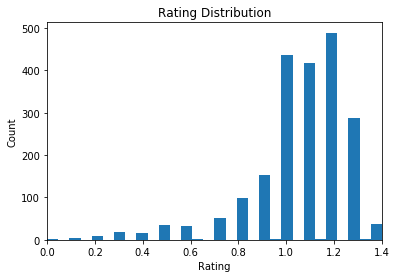

In [80]:
plt.hist(x = archive.rating, bins = 30)
plt.xlim(0,1.4)
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Rating Distribution');
plt.savefig('rating_distribution.png')
plt.show()

Most people rates the dog above 1.0. Nearly 500 people rates dog at 1.2.

#### Dog Breed

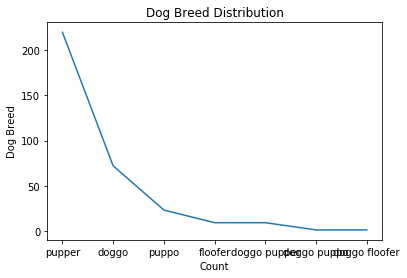

In [81]:
counts = archive["breed"].value_counts()
plt.plot(range(len(counts)), counts)
plt.xticks(range(len(counts)), counts.index)
plt.xlabel('Count');
plt.ylabel('Dog Breed');
plt.title('Dog Breed Distribution');
plt.savefig('breed_distribution.png')
plt.show()

Most of tweet dog breed is pupper, then doggo and puppo. Floofer has the smallest amount.

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


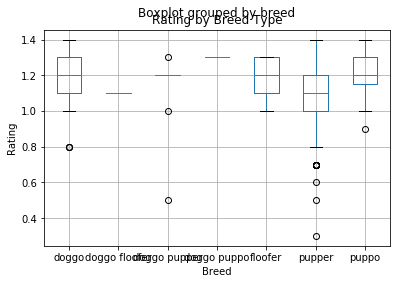

In [82]:
archive.boxplot(column='rating', by='breed')
plt.xlabel('Breed');
plt.ylabel('Rating');
plt.title('Rating by Breed Type');
plt.savefig('rating_breed.png')
plt.show()

Rating of puppo is generally higher than rest of breed type. Pupper has the rating lower than dogoo and floofer.

In [83]:
archive["timestamp"] = pd.to_datetime(archive["timestamp"])
archive.set_index('timestamp', inplace=True)

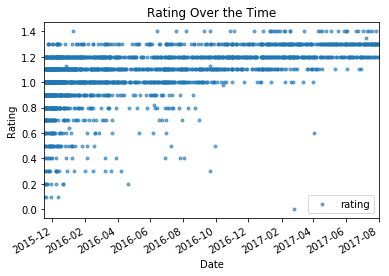

In [84]:
archive[['rating']].plot(style = '.', alpha = 0.6)
plt.title('Rating Over the Time')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.savefig('rating_time.png')
plt.show()

From Dec 2015 to Oct 2016, We still can see people rate the dog below 1.0. However, people seems like they always rate dog above 1.0, and the rating score 1.2 is the most popular score. But has less rating score is 1.4. 

#### Retweet Count & Favorite Count

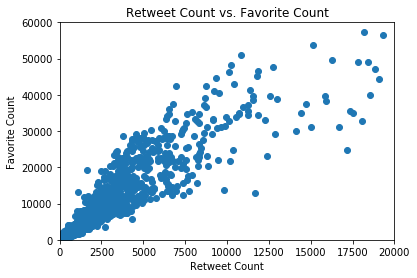

In [85]:
plt.scatter(x = archive.retweet_count, y = archive.favorite_count)
plt.xlim(0, 20000)
plt.ylim(0, 60000)
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');
plt.title('Retweet Count vs. Favorite Count');
plt.savefig('retweet_favorite.png')
plt.show()

The retweet count and favorite count show linear relationship.

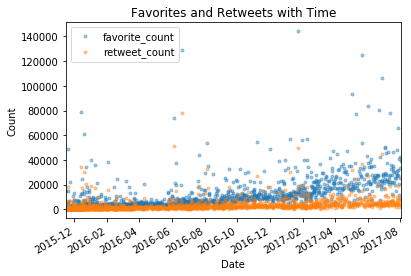

In [86]:
archive[['favorite_count', 'retweet_count']].plot(style = '.', alpha = 0.4)
plt.title('Favorites and Retweets with Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.savefig('favorite_retweet_time.png')
plt.show()

Number of fovorite counts increased after 2016. Some even has counts over 100,000. 
Retweet counts was very stable over the time. Only June 2016 it reached to the peak (nearly 80,000 counts).

#### Top 10 dogs

In [87]:
top10_dogs = archive.loc[archive.p1.isin(archive.p1.value_counts().head(10).index)]

In [88]:
top10_mean = top10_dogs.groupby('p1').mean()
top10_mean

,tweet_id,rating,img_num,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count
p1,,,,,,,,
chihuahua,723302386658917888,1.058108,1.243243,0.589630,0.113401,0.061369,1797.824324,6613.716216
chow,752167903264139264,1.157895,1.315789,0.647135,0.116666,0.056577,2721.263158,9797.500000
golden_retriever,757441965198101760,1.158945,1.320000,0.724531,0.110106,0.044954,3333.264000,11689.488000
labrador_retriever,745875694992332416,1.112360,1.157303,0.648167,0.143523,0.054126,3345.292135,10466.617978
malamute,748834740286357888,1.089286,1.250000,0.597106,0.186396,0.083146,2442.428571,8488.571429
pembroke,754542332439499392,1.142529,1.252874,0.716166,0.140587,0.041328,2968.379310,10680.218391
pomeranian,719764311035460608,1.115132,1.342105,0.743606,0.103489,0.037442,2810.473684,8021.342105
pug,715978065874798464,1.019231,1.134615,0.764010,0.088990,0.035044,1613.288462,5411.653846
samoyed,749569562849255936,1.170270,1.135135,0.754121,0.099468,0.038725,4152.702703,12502.216216


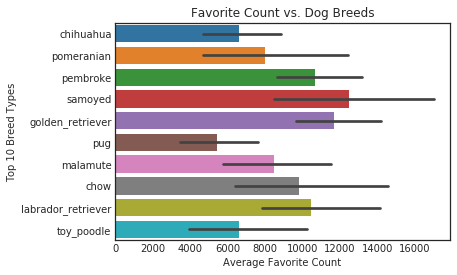

In [89]:
sns.set_style('white')
favorite_top10_dogs = sns.barplot(x = 'favorite_count', y = 'p1', data = top10_dogs)
favorite_top10_dogs.set_ylabel('Top 10 Breed Types')
favorite_top10_dogs.set_xlabel('Average Favorite Count')
favorite_top10_dogs.set_title('Favorite Count vs. Dog Breeds')

fig = favorite_top10_dogs.get_figure()
fig.savefig('favorite_top10_dogs.png')

Samoyed gets the highest average favorite counts among top 10 popular dogs.
Pug gets the lowest average favorite counts among top 10 popular dogs.

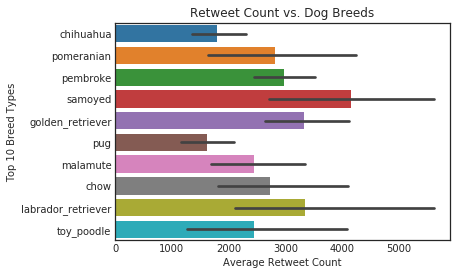

In [90]:
sns.set_style('white')
retweet_top10_dogs = sns.barplot(x = 'retweet_count', y = 'p1', data = top10_dogs)
retweet_top10_dogs.set_ylabel('Top 10 Breed Types')
retweet_top10_dogs.set_xlabel('Average Retweet Count')
retweet_top10_dogs.set_title('Retweet Count vs. Dog Breeds')

fig = retweet_top10_dogs.get_figure()
fig.savefig('retweet_top10_dogs.png')

Samoyed gets the highest average retweet counts among top 10 popular dogs.
Pug gets the lowest average retweet counts among top 10 popular dogs.

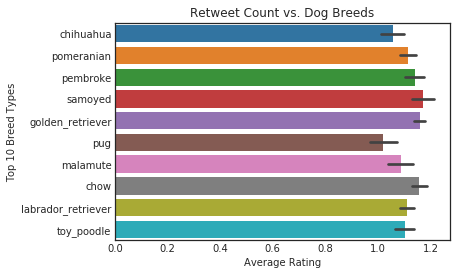

In [91]:
sns.set_style('white')
rating_top10_dogs = sns.barplot(x = 'rating', y = 'p1', data = top10_dogs)
rating_top10_dogs.set_ylabel('Top 10 Breed Types')
rating_top10_dogs.set_xlabel('Average Rating')
rating_top10_dogs.set_title('Retweet Count vs. Dog Breeds')

fig = rating_top10_dogs.get_figure()
fig.savefig('rating_top10_dogs.png')

Average ratings of the top 10 dogs are all over 1.0. Among them, samoyed can get the highest average rating which is almost 1.2.